@author: Pavlo Mospan

### All needed impots

In [1]:
import os
import numpy as np
from datetime import datetime, date, timedelta

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 5.5MB 18.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=ab26b0e387db15c959cc33032eef5cc0a1a65e1d6343913d628176a2b3d2cb42
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


### Downloading Bitcoin dataframe with yahoo finance API and then plotting this DF

**reset_index** method is used only to make normal numerical indexes, instead of *Date* beeing an index


In [2]:
df = yf.download('BTC-USD', start='2015-08-07')
df = df.reset_index()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,279.584991,42484800
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,260.997009,58533000
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,265.083008,23789600
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,264.470001,20979400
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,270.385986,25433900
...,...,...,...,...,...,...,...
2001,2021-02-01,33114.578125,34638.214844,32384.228516,33537.175781,33537.175781,61400400660
2002,2021-02-02,33533.199219,35896.882812,33489.218750,35510.289062,35510.289062,63088585433
2003,2021-02-03,35510.820312,37480.187500,35443.984375,37472.089844,37472.089844,61166818159
2004,2021-02-04,37475.105469,38592.175781,36317.500000,36926.066406,36926.066406,68838074392


Text(0, 0.5, 'Close Price (USD)')

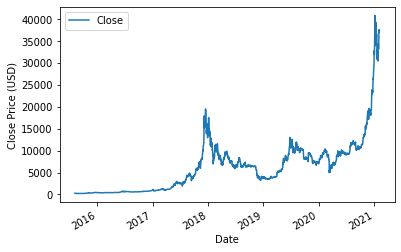

In [3]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

### Normalization

Since the scaler expects the data to be shaped as (x, y), I'm adding a dummy dimension using reshape before applying it. 

**reshape** method transforms array of *Closed* values from shape (2001, 1) into (2001, 1)

In [4]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

scaled_close.shape, np.isnan(scaled_close).any()

((2006, 1), False)

### Preprocessing

 LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is: **[batch_size, sequence_length, n_features]**

 The process of building sequences works by creating a sequence of a specified length at position 0. Then it's shifted one position to the right (e.g. 1) and creates another sequence. The process is repeated until all possible positions are used.

 Here, *SEQ_LEN* parameter is set to 20, which means, that 20 days are predicting the next one

In [5]:
SEQ_LEN = 20
whole_data = np.empty([1, 20, 1])
whole_targets = np.empty([1, 1])

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len + 1):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    global whole_data, whole_targets
    whole_data = to_sequences(data_raw, seq_len)
    whole_targets = whole_data[:, -1, :]
    print('whole_data: ', whole_data.shape)
    print('whole_targets: ', whole_targets.shape)

    num_train = int(train_split * whole_data.shape[0])

    X_train = whole_data[:num_train, :, :]
    y_train = whole_data[:num_train, -1, :]

    X_test = whole_data[num_train:, :, :]
    y_test = whole_data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

X_train.shape, X_test.shape

whole_data:  (1987, 20, 1)
whole_targets:  (1987, 1)


((1887, 20, 1), (100, 20, 1))

#### Simply checking arrays if everything's alright

In [6]:
# Last 20 scaled values of the DataFrame
scaled_close[-20:], scaled_close.shape

(array([[0.87665218],
        [0.89731876],
        [0.88351464],
        [0.87065207],
        [0.75430847],
        [0.80802164],
        [0.78490792],
        [0.79037114],
        [0.79226863],
        [0.79728148],
        [0.74462184],
        [0.77460817],
        [0.84031329],
        [0.83915866],
        [0.81069731],
        [0.82111481],
        [0.86972909],
        [0.91806465],
        [0.90461152],
        [0.91896789]]), (2006, 1))

In [7]:
print('The last 2 sequences from whole sequenced data and it\'s shape: \n {} | {} \n Last 5 values to predict (simple values from DF) : \n \
    {}'.format(whole_data[-2:], whole_data.shape, whole_targets[-5:]))

The last 2 sequences from whole sequenced data and it's shape: 
 [[[0.88618386]
  [0.87665218]
  [0.89731876]
  [0.88351464]
  [0.87065207]
  [0.75430847]
  [0.80802164]
  [0.78490792]
  [0.79037114]
  [0.79226863]
  [0.79728148]
  [0.74462184]
  [0.77460817]
  [0.84031329]
  [0.83915866]
  [0.81069731]
  [0.82111481]
  [0.86972909]
  [0.91806465]
  [0.90461152]]

 [[0.87665218]
  [0.89731876]
  [0.88351464]
  [0.87065207]
  [0.75430847]
  [0.80802164]
  [0.78490792]
  [0.79037114]
  [0.79226863]
  [0.79728148]
  [0.74462184]
  [0.77460817]
  [0.84031329]
  [0.83915866]
  [0.81069731]
  [0.82111481]
  [0.86972909]
  [0.91806465]
  [0.90461152]
  [0.91896789]]] | (1987, 20, 1) 
 Last 5 values to predict (simple values from DF) : 
     [[0.82111481]
 [0.86972909]
 [0.91806465]
 [0.90461152]
 [0.91896789]]


In [8]:
X_test[-1], X_test.shape

(array([[0.87665218],
        [0.89731876],
        [0.88351464],
        [0.87065207],
        [0.75430847],
        [0.80802164],
        [0.78490792],
        [0.79037114],
        [0.79226863],
        [0.79728148],
        [0.74462184],
        [0.77460817],
        [0.84031329],
        [0.83915866],
        [0.81069731],
        [0.82111481],
        [0.86972909],
        [0.91806465],
        [0.90461152],
        [0.91896789]]), (100, 20, 1))

In [9]:
y_test[-5:], y_test.shape

(array([[0.82111481],
        [0.86972909],
        [0.91806465],
        [0.90461152],
        [0.91896789]]), (100, 1))

### Model

Bidirectional RNNs allows us to train on the sequence data in forward and backward (reversed) direction. In practice, this approach works well with LSTMs.

The output layer has a single neuron (predicted Bitcoin price). 

In [10]:
DROPOUT = 0.1
WINDOW_SIZE = SEQ_LEN 

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 20, 40)            3520      
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 80)            25920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 80)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                16160     
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
activation (Activation)      (None, 1)                 0

### Training

In [11]:
BATCH_SIZE = 64
EPOCHS = 120

history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/120
27/27 [==============================] - 15s 86ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 2/120
27/27 [==============================] - 0s 15ms/step - loss: 0.0059 - val_loss: 5.2923e-04
Epoch 3/120
27/27 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 3.2929e-04
Epoch 4/120
27/27 [==============================] - 0s 15ms/step - loss: 8.6892e-04 - val_loss: 2.1012e-04
Epoch 5/120
27/27 [==============================] - 1s 21ms/step - loss: 5.4836e-04 - val_loss: 2.1353e-04
Epoch 6/120
27/27 [==============================] - 0s 15ms/step - loss: 4.4740e-04 - val_loss: 2.3007e-04
Epoch 7/120
27/27 [==============================] - 0s 16ms/step - loss: 4.4981e-04 - val_loss: 2.5372e-04
Epoch 8/120
27/27 [==============================] - 0s 16ms/step - loss: 4.8505e-04 - val_loss: 2.8632e-04
Epoch 9/120
27/27 [==============================] - 0s 15ms/step - loss: 5.5776e-04 - val_loss: 2.7938e-04
Epoch 10/120
27/27 [=======================

In [12]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 5.8988e-04


0.0005898816161789

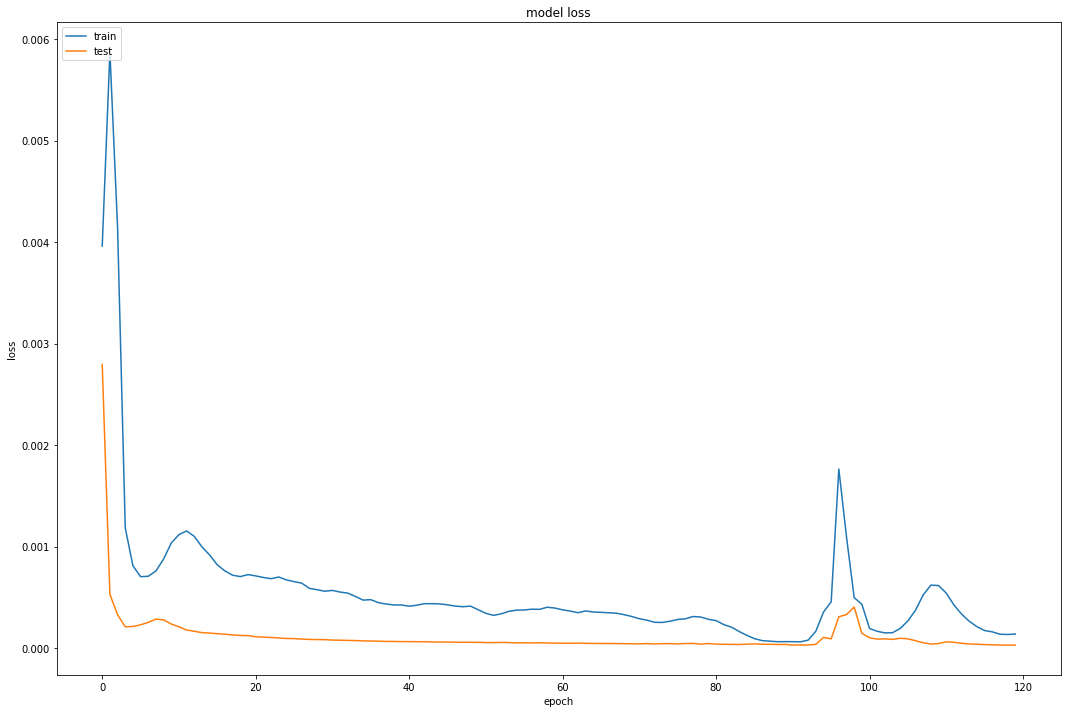

In [13]:
plt.figure(figsize = (18,12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction on Test Data

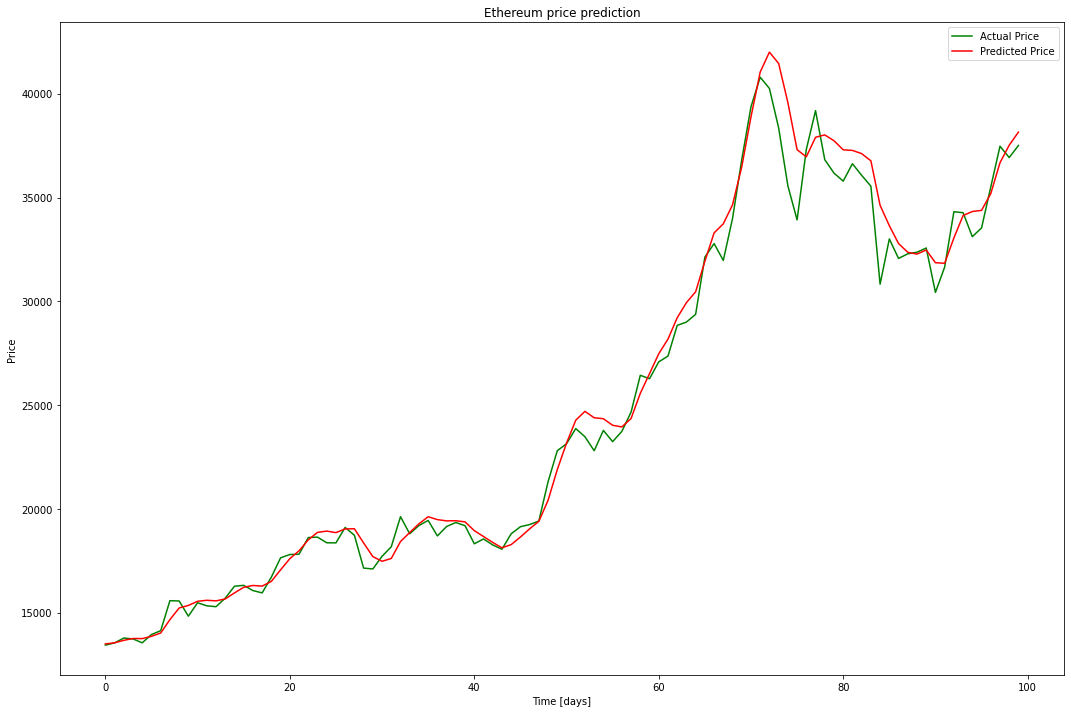

In [14]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize = (18,12))
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

Checking some real (*y_test_inverse*) and predicted *y_hat_inverse* values

In [15]:
y_test_inverse[85:]

array([[33005.76171875],
       [32067.64257812],
       [32289.37890625],
       [32366.39257812],
       [32569.84960938],
       [30432.546875  ],
       [31649.60546875],
       [34316.38671875],
       [34269.5234375 ],
       [33114.359375  ],
       [33537.17578125],
       [35510.2890625 ],
       [37472.08984375],
       [36926.06640625],
       [37508.75      ]])

In [16]:
y_hat_inverse[85:]

array([[33645.33 ],
       [32786.13 ],
       [32362.46 ],
       [32277.105],
       [32472.479],
       [31861.88 ],
       [31832.814],
       [33051.492],
       [34134.   ],
       [34327.89 ],
       [34382.18 ],
       [35189.094],
       [36679.637],
       [37522.58 ],
       [38152.11 ]], dtype=float32)

In [17]:
df.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume
1991,2021-01-22,30817.625000,33811.851562,28953.373047,33005.761719,33005.761719,77207272511
1992,2021-01-23,32985.757812,33360.976562,31493.160156,32067.642578,32067.642578,48354737975
1993,2021-01-24,32064.376953,32944.007812,31106.685547,32289.378906,32289.378906,48643830599
1994,2021-01-25,32285.798828,34802.742188,32087.787109,32366.392578,32366.392578,59897054838
1995,2021-01-26,32358.613281,32794.550781,31030.265625,32569.849609,32569.849609,60255421470
1996,2021-01-27,32564.029297,32564.029297,29367.138672,30432.546875,30432.546875,62576762015
1997,2021-01-28,30441.041016,31891.300781,30023.207031,31649.605469,31649.605469,78948162368
1998,2021-01-29,34318.671875,38406.261719,32064.814453,34316.386719,34316.386719,117894572511
1999,2021-01-30,34295.933594,34834.707031,32940.187500,34269.523438,34269.523438,65141828798
2000,2021-01-31,34270.878906,34288.332031,32270.175781,33114.359375,33114.359375,52754542671


### Now, predicting into the future.

Since 20 values are predicting the next one and there is no value for tomorrow to make prediction upon, I'm gonna make an artificial dummy values for that. I'm making a new sequence, where the last value will be repeated twice (inserting a dummy data) : if the last value for today is *[0.94239681]*, then this value will be set for tomorrow

Prediction array will be : pred_array

Target arrays will be:  targ_array

In [18]:
def get_prediction_array(X):
  """
  Inserts an other array to the end of the whole_data sequence in order to make
  array for predicting tomorrow's value

  returns: array of shape (None, 20, 1)
  """
  next = len(X)
  a = np.insert(X,[next],X[next-1], axis=0)
  for i_ in range(len(a[100]) - 1):
    if(i_ == 20):
      a[next][i_][0] == a[next][i_ - 1][0]
    else:
      a[next][i_][0] = a[next][i_ + 1][0]
  
  return a

In [19]:
pred_array = get_prediction_array(whole_data)
pred_array.shape

(1988, 20, 1)

In [20]:
pred_array[-2:], pred_array.shape

(array([[[0.87665218],
         [0.89731876],
         [0.88351464],
         [0.87065207],
         [0.75430847],
         [0.80802164],
         [0.78490792],
         [0.79037114],
         [0.79226863],
         [0.79728148],
         [0.74462184],
         [0.77460817],
         [0.84031329],
         [0.83915866],
         [0.81069731],
         [0.82111481],
         [0.86972909],
         [0.91806465],
         [0.90461152],
         [0.91896789]],
 
        [[0.89731876],
         [0.88351464],
         [0.87065207],
         [0.75430847],
         [0.80802164],
         [0.78490792],
         [0.79037114],
         [0.79226863],
         [0.79728148],
         [0.74462184],
         [0.77460817],
         [0.84031329],
         [0.83915866],
         [0.81069731],
         [0.82111481],
         [0.86972909],
         [0.91806465],
         [0.90461152],
         [0.91896789],
         [0.91896789]]]), (1988, 20, 1))

In [21]:
targ_array = get_prediction_array(whole_targets)
targ_array.shape 

(1988, 1)

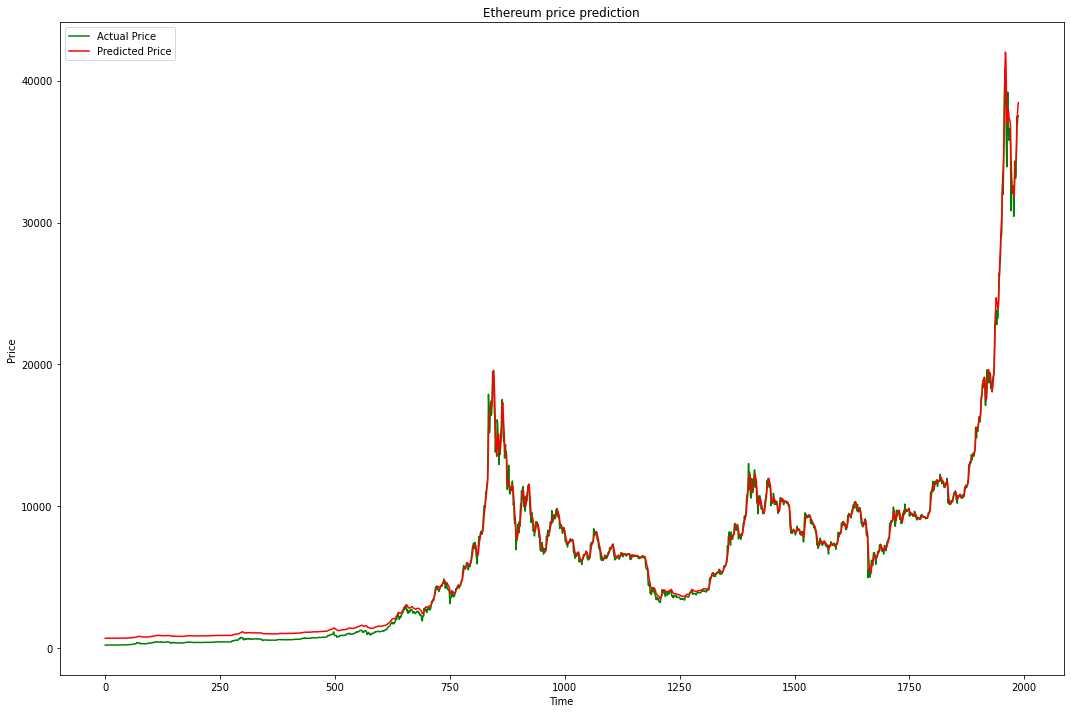

In [22]:
y_hat = model.predict(pred_array)

y_true_inverse = scaler.inverse_transform(targ_array)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.figure(figsize = (18,12))
plt.plot(y_true_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [23]:
print('Predicted Ethereum price for the next day: {} and predicted Ethereum price for the next day: {}'.format(y_hat_inverse[-1], y_true_inverse[-1]))

Predicted Ethereum price for the next day: [38445.3] and predicted Ethereum price for the next day: [37508.75]


### Making a dataset of data-predicted-true values


**NOTE** - prediction starts from 20th **(SEQ_LEN)** day from *2015-08-07* (the first day data was received inf DF from).
This means, that the first *SEQ_LEN = 20* values do not have any prediction at all

In [24]:
# number of rows in DF
num_data_points = df.index.stop
# where the sequence prediction started from
started_ = num_data_points - len(y_true_inverse) + 1

In [25]:
tomorrow = date.today() + timedelta(days=1)
tomorrow = tomorrow.strftime('%Y-%m-%d')

ds = []

for i_ in df.Date[started_:]:
  ds.append(i_.strftime('%Y-%m-%d'))

ds.append(tomorrow)

print(len(ds), ds[-2:])

1988 ['2021-02-05', '2021-02-06']


### Last *true* value in **forecast** DataFrame is set to zero

In [26]:
y_true = y_true_inverse.reshape(len(y_true_inverse),)
y_true[-1] = 0
y_pred = y_hat_inverse.reshape(len(y_hat_inverse),)

d = {"ds": ds, "true": y_true, 'pred' : y_pred}
forecast = pd.DataFrame(d)
forecast

,ds,true,pred
0,2015-08-26,225.830994,708.260620
1,2015-08-27,224.768997,708.061646
2,2015-08-28,231.395996,709.098572
3,2015-08-29,229.779999,709.938599
4,2015-08-30,228.761002,710.415527
...,...,...,...
1983,2021-02-02,35510.289062,35189.097656
1984,2021-02-03,37472.089844,36679.636719
1985,2021-02-04,36926.066406,37522.578125
1986,2021-02-05,37508.750000,38152.109375


In [27]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,279.584991,42484800
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,260.997009,58533000
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,265.083008,23789600
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,264.470001,20979400
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,270.385986,25433900
...,...,...,...,...,...,...,...
2001,2021-02-01,33114.578125,34638.214844,32384.228516,33537.175781,33537.175781,61400400660
2002,2021-02-02,33533.199219,35896.882812,33489.218750,35510.289062,35510.289062,63088585433
2003,2021-02-03,35510.820312,37480.187500,35443.984375,37472.089844,37472.089844,61166818159
2004,2021-02-04,37475.105469,38592.175781,36317.500000,36926.066406,36926.066406,68838074392


### Saving the model


In [28]:
file_name = 'BidirectLSTM_BTC-1f.h5'
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `BidirectLSTM_BTC-1f.h5` to disk
